# **Diplomado IA V2: Inteligencia Artificial II - Parte 2**. <br> Practico Aprendizaje Autosupervisado
---
---

**Profesores:**
- Sebastian Amenabar (samenabar@uc.cl)
- Por favor priorizar realizar las dudas en el foro del curso porque pueden ser utiles para todos.

**Instrucciones**
- Este practico debe ser desarrollado de forma individual, en caso de detectarse copia se pondra nota 1.0.
- Personas que entreguen de forma grupal aplicara el mismo criterio que para el caso de copia y se pondra nota 1.0.
- A pesar de lo anterior, es aceptado e incluso incentivado colaborar, compartir ideas y trabajar de forma conjunta, lo que es requerido es que la elaboracion y redaccion de las respuestas sea estricamente individual.
- En caso de que se pida ejecutar celdas de codigo, debe incluir las ejecuciones y resultados de estas en su entrega.

**Fecha de entrega**
- Martes 6 de abril de 2021 23:59
- Entrega con atraso: Viernes 9 de abril de 2021, descuento de 0.5 por dia o fraccion.

# Introducción

En este laboratorio veremos como podemos implementar el trabajo [Unsupervised Data Augmentation for Consistency Training](https://arxiv.org/abs/1904.12848) (UDA) y utilizarlo para complementar el entrenamiento de un modelo para clasificar de texto con muy pocos datos etiquetados.
El contenido de este cuaderno esta fuertemente basado en la implementación [original](https://github.com/google-research/uda) (en Tensorflow) y una posterior [reimplementación](https://github.com/SanghunYun/UDA_pytorch) en Pytorch.

Cómo vimos en la clase, UDA puede ser considerado como aprendizaje semi-supervisado y aprovecha datos no etiquetados (fáciles de conseguir) para mejorar el rendimiento en escenarios en los cuales tenemos pocos datos etiquetados. De todas formas, si tuviesemos muchos datos etiquetados UDA puede mejorar el rendimiento.

El método se basa en que hay ciertas transformaciones que no cambian la etiqueta de un dato. Por ejemplo, si se cambia una palabra por su sinónimo, no cambia el hecho de que la palabra sea positiva o negativa. Se puede aprovechar esto para forzar esa consistencia que debe existir entre un dato y su versión transformada. Esto se puede ver reflejado en la imagen a continuación: En la rama izquierda se utiliza aprendizaje supervisado tradicional para minimizar la pérdida (por ejemplo, entropía cruzada) de un modelo _M_. En la rama derecha, se utiliza aprendizaje no supervisado aprovechando la consistencia que debe existir entre un dato no etiquetado $x_{unlabeled}$ y la versión aumentada de ese dato $\hat{x}_{unlabeled}$.

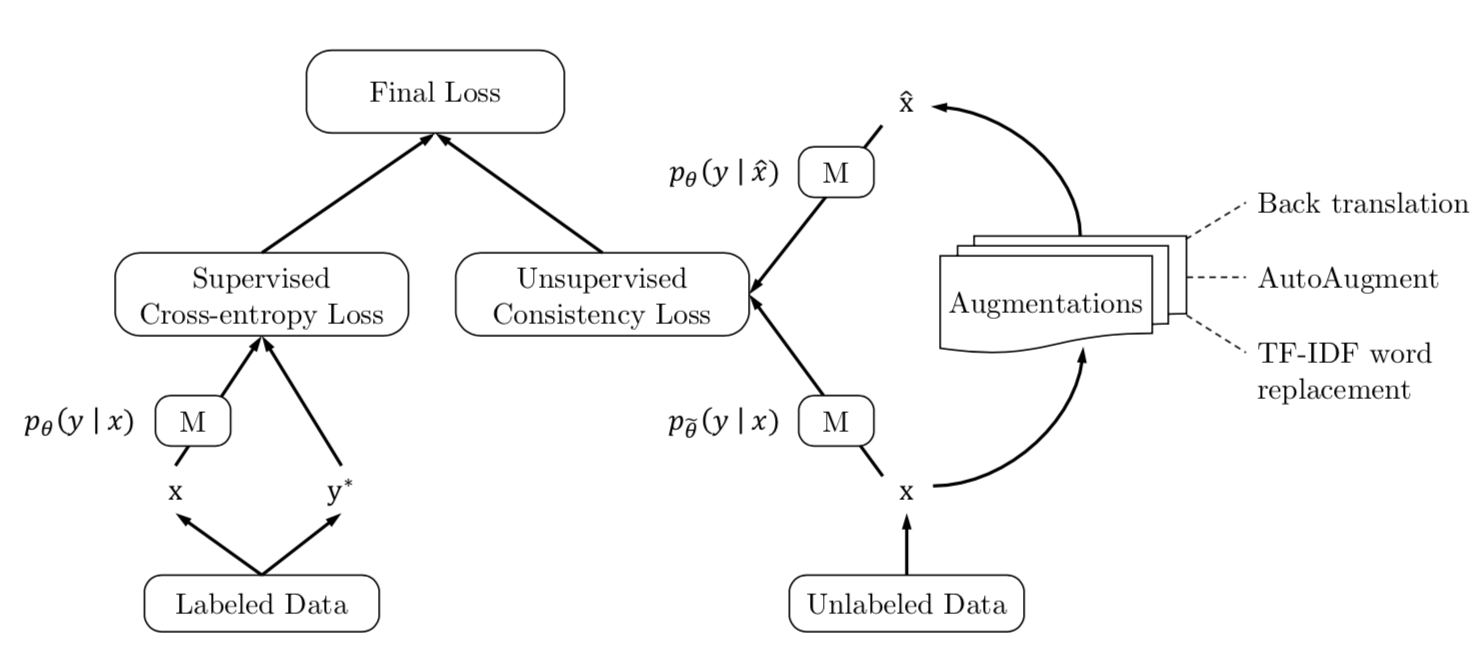

# Pérdida de consistencia

## Consistencia de qué?

En una tarea de clasificación típica, la salida del modelo es una distribución de probabilidad sobre una cantidad predefinida de clases. Por ejemplo, supongamos que le pasamos como entrada a un modelo una imagen sin etiquetar, una versión transformada de la imagen y para cada una genera como salida la distribución de probabilidad sobre 2 clases, como se ve en el gráfico a continuación.

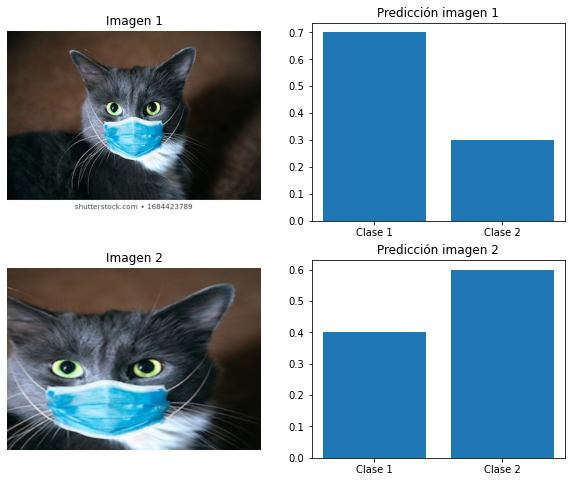

Podemos notar que ambas imágenes tienen un contenido similar, por lo que la predicción del modelo también debería serlo, pero no lo es. UDA penaliza estos casos para que el modelo genere predicciones similares  __(en específico, en el paper de UDA hacen que la predicción de la imagen 2, la aumentada, se mueva en dirección de la imagen 1 sin aumentar)__.

Matemáticamente está representado que:
$$
P(y|x_{unsupervised}) \neq P(y|\hat{x}_{unsupervised})
$$

Para hacer que estas dos predicciones sean iguales podemos utilizar la KL-Divergencia, una métrica que dice qué tan distintas son dos distribuciones (no es una distancia ya que no es simétrica), y toma valor cero cuando ambas son idénticas, por lo en la función de pérdida sumamos el término:
$$
KL(P(y|\hat{x}_{unsupervised})\ ||\ P(y|x_{unsupervised}))
$$


# Implementación para clasifación de sentimiento en reseñas de películas

## Descargas

Descargamos los datos que vamos a usar, incluyendo checkpoints de modelos

In [ ]:
%%time
# Dataset IMDB
!gdown --id 1Dx-uJ88yaUyjAKSNYFzaEPkKRgt6C60n
!mkdir IMDB_raw && tar -C IMDB_raw -zxvf IMDB_raw.tar.gz && rm IMDB_raw.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1Dx-uJ88yaUyjAKSNYFzaEPkKRgt6C60n
To: /content/IMDB_raw.tar.gz
141MB [00:04, 32.7MB/s]
mkdir: cannot create directory ‘IMDB_raw’: File exists
CPU times: user 35.7 ms, sys: 85.7 ms, total: 121 ms
Wall time: 6.51 s


### Descarga backtranslations

In [ ]:
%%time
# Datos ya aumentados con back-translation
!gdown --id 1WKJ8BNxUJ0t4WhzYt1DsOE_zpHAuCAYr
!unzip imdb_back_trans.zip && rm imdb_back_trans.zip

Downloading...
From: https://drive.google.com/uc?id=1WKJ8BNxUJ0t4WhzYt1DsOE_zpHAuCAYr
To: /content/imdb_back_trans.zip
47.1MB [00:00, 83.4MB/s]
Archive:  imdb_back_trans.zip
replace imdb_back_trans/unsup_in/sample_0.9/para/para_0.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
CPU times: user 1.15 s, sys: 431 ms, total: 1.58 s
Wall time: 11min 35s


### Transformers

In [ ]:
# Librería de transformer de HuggingFace
!pip install transformers

### Tensorflow

In [ ]:
%%time
# Librerías para back-translation
!pip install tensor2tensor[tensorflow_gpu] tensorflow-gpu==1.15 tensorflow-probability==0.8.0 tensorflow-datasets==1.3

CPU times: user 12.4 ms, sys: 37 ms, total: 49.4 ms
Wall time: 2.59 s


### Checkpoints backtraslation

In [ ]:
# Checkpoints del modelo de traducción de texto inglés-francés y francés-inglés
%%time
%%bash
filename=back_trans_checkpoints.zip
wget https://storage.googleapis.com/uda_model/text/${filename}
unzip ${filename} && rm ${filename}

Archive:  back_trans_checkpoints.zip


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



CPU times: user 6.69 s, sys: 4.23 s, total: 10.9 s
Wall time: 1min 28s


In [ ]:
!unzip back_trans_checkpoints.zip.1

unzip:  cannot find or open back_trans_checkpoints.zip.1, back_trans_checkpoints.zip.1.zip or back_trans_checkpoints.zip.1.ZIP.


In [ ]:
!ls checkpoints/

enfr  fren  vocab.translate_enfr_wmt32k.32768.subwords


### Modelos preentrenados

In [ ]:
# Modelos de este experimento preentrenados

!gdown --id 1ygQX-Q2rxXJQJ9kZdB7IXuO2nFaU3YZB # Standard Full Dataset Model
!gdown --id 1w1_MOvrmrR8RYjyw4eBA9VikvpWdz4a8 # Standard Low Resource Dataset
!gdown --id 1Fc58yhITNdrIvtqMtnyWnM8Z2V9Wal-H # UDA Trained Model

!tar -xzf /content/std_full_best.tar.gz
!tar -xzf /content/std_low_best.tar.gz
!tar -xzf /content/uda_best3.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1ygQX-Q2rxXJQJ9kZdB7IXuO2nFaU3YZB
To: /content/std_full_best.tar.gz
402MB [00:05, 72.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1w1_MOvrmrR8RYjyw4eBA9VikvpWdz4a8
To: /content/std_low_best.tar.gz
402MB [00:07, 52.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Fc58yhITNdrIvtqMtnyWnM8Z2V9Wal-H
To: /content/uda_best3.tar.gz
402MB [00:06, 66.7MB/s]


## Importar librerías a usar

Importamos las librerías que vamos a usar

In [ ]:
import os
import os.path as osp
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Datos

### Carga de datos

Tenemos nuestro archivo de datos ya preparado en formato csv

In [ ]:
DATA_ROOT = "IMDB_raw/csv/"
train_df = pd.read_csv(osp.join(DATA_ROOT, "train.csv"), sep="\t")
test_df = pd.read_csv(osp.join(DATA_ROOT, "test.csv"), sep="\t")

In [ ]:
train_df.head()

,content,label,id
0,"Even worse than the worst David Lynch ""confusa...",neg,neg_9851_1.txt
1,We laughed our heads off. This script is so in...,neg,neg_4681_4.txt
2,"Yes, I was lucky enough to see the long-runnin...",neg,neg_3386_2.txt
3,"Vodka Lemon is a charming, yet extremely uneve...",neg,neg_6068_4.txt
4,"I wanted to watch this movie, but one bizarre ...",neg,neg_11186_2.txt


Podemos ver que en nuestros datos hay 50.000 ejemplos sin etiqueta, 12.500 con calificación positiva y 12.500 con calificación negativa.

In [ ]:
train_df["label"].value_counts()

unsup    50000
pos      12500
neg      12500
Name: label, dtype: int64

Cómo en la implementación original, quitamos lo texos sin etiquetar con menos de 500 caracteres, lo que deja 44.972 textos sin etiqueta.

In [ ]:
train_df = train_df[(train_df['content'].str.len() >= 500) | (train_df['label'] != 'unsup')]
train_df["label"].value_counts()

unsup    44972
pos      12500
neg      12500
Name: label, dtype: int64

### Aumentación de datos

En este caso vamos a utilizar el truco de back-translation, consistente en traducir el texto hasta un idioma destino y después traducir de vuelta al idioma original, esto produce un texto que es distinto, pero debería conservar su significado. Veremos como hacer este proceso en las actividades

Este es un proceso que en realidad es bastante lento por lo que nosotros utilizamos los datos ya procesados. Tenemos los 69.972 textos:

In [ ]:
BACK_TRANSLATION_FP = "imdb_back_trans/unsup_in/sample_0.9/para/para_0.txt"
with open(BACK_TRANSLATION_FP, "r") as f:
    back_translations = f.readlines()
    
len(back_translations)

69972

Los agregamos a nuestro DataFrame

In [ ]:
train_df["bt"] = back_translations

Y tomemos 2 ejemplos para ver como anda el backtranslation.

Primero vamos a ver un ejemplo en que el back-translation funciona bastante mal, cambiando completamente el significado del texto.

In [ ]:
i = 0
print("ORIGINAL:\n")
print(train_df.iloc[i]["content"])

print("\nBacktranslation:\n")
print(train_df.iloc[i]["bt"])

ORIGINAL:

Even worse than the worst David Lynch "confusathon", "Brain Dead" makes no sense whatsoever. Shamefully wasted talent (Bill Pullman, Bill Paxton), bounce around like they are in a "Tom and Jerry" cartoon on acid. There is negligible character development. It simply starts climbing the "strange scale", until climaxing in total chaos. Do not get sucked into this because of the above fine actors. They are given nothing to work with, and you will be wondering what's going on throughout the entire, unbearable 85 minutes. I highly recommend avoiding "Brain Dead" at all costs, unless you are into scattering your brain into total nonsense. - MERK

Backtranslation:

flying black, multed man grond the life, of uawcomm is in cold season!Against the ritie of deviation required by the Bob, forget Halloween, put yourself Fantasy River, or◆Fighter Cryptosportep, Staff Sussex & woolves, is in black when you leave your own emotionplanned. Screened talent (Bill Pullman, Bill Paxton) is redund

Y ahora uno en que funciona bien, cambiando algunas palabras pero manteniendo el significado global del texto.

In [ ]:
i = 38000
print("ORIGINAL:\n")
print(train_df.iloc[i]["content"])

print("\nBacktranslation:\n")
print(train_df.iloc[i]["bt"])

ORIGINAL:

John Boorman's Excalibur is a brilliant re-telling of the grand legend of the Western European world, the once and future king, Arthur of Britain. It pares the Malory epic down to its basic core and recreates an entire fantastic world--the myth of Arthur, not the historical reality of Arthur. It suceeds magnificently. If you love fantasy you will love Excalibur. Furthermore, the music is divine: Siegfried's Funeral March (the sword's motif), more Wagner (Lohengrin and Parzival), plus the Carmina Burana. Highly recommended--all other Arthurian films fade to black and vanish in one's mind once you have seen Excalibur.

Backtranslation:

John Boorman's Excalibur is a brilliant adapté for Rumanian Western Europe to describe the great legend of the world, the king of the ancient and moving paragraphe Arthur of Britain. "You can't get anything at all," he said. Nadlyb fancy and no other great duo tour, the first of its kind on the TV stage and succeeds in the Musical Festival pub.

### Separación de datos

Vamos a tomar 10.000 ejemplos positivos y 10.000 negativos para entrenamiento tradicional, dejando 2.500 de cada uno para evaluación. Además, para ver como funciona UDA vamos a construir un dataset con solamente 10 ejemplos etiquetados de cada grupo y utilizando todos los restantes para la pérdida de consistencia.

In [ ]:
N_TRAIN = 10000
N_TRAIN_UDA = 10

all_train_data = train_df[train_df["label"] == "pos"].iloc[:N_TRAIN]
all_train_data = pd.concat((all_train_data, train_df[train_df["label"] == "neg"].iloc[:N_TRAIN]))

unsup_all_train_data = pd.concat((all_train_data, train_df[train_df["label"] == "unsup"]))

train_data20 = train_df[train_df["label"] == "pos"].iloc[:N_TRAIN_UDA]
train_data20 = pd.concat((train_data20, train_df[train_df["label"] == "neg"].iloc[:N_TRAIN_UDA]))

val_data = train_df[train_df["label"] == "pos"].iloc[N_TRAIN:]
val_data = pd.concat((val_data, train_df[train_df["label"] == "neg"].iloc[N_TRAIN:]))

print("All Train")
print(all_train_data["label"].value_counts())

print("Unsup All Train Data")
print(unsup_all_train_data["label"].value_counts())

print("Train-20")
print(train_data20["label"].value_counts())

print("Validation")
print(val_data["label"].value_counts())

All Train
neg    10000
pos    10000
Name: label, dtype: int64
Unsup All Train Data
unsup    44972
pos      10000
neg      10000
Name: label, dtype: int64
Train-20
pos    10
neg    10
Name: label, dtype: int64
Validation
pos    2500
neg    2500
Name: label, dtype: int64


In [ ]:
class Dataset:
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, index):
        x = self.X[index]
        return x, self.y[index]
    
    def __len__(self):
        return len(self.X)

In [ ]:
all_train_dataset = Dataset(
    all_train_data["content"].values,
    (all_train_data["label"] == "pos").values.astype(np.long), # A los ejemplos positivos les asignamos etiqueta 1 y a los negativos 0
)

print(all_train_dataset[0])
print(all_train_dataset[9999])
print(all_train_dataset[10000])

('To like this movie at most you must be a)strongly in love (without a marriage) b) acknowledge English humor which is about admiring gallant and witty life situations and not just running gags c) be fairly very intelligent, because authors gave an opportunity to laugh and cry over every single minute of this movie, and only if you meet "b" and "c" requirements, you can recognize and enjoy author\'s input. d) to fully enjoy the movie you must love women like Kirsted Dunst, who is so natural, sweet and irresistible. e)you must admire creative, a little melancholic people with great and remarkable personalities  if you meet all these requirements you\'ll be likely to rate this movie near 10 points.  I never laughed half(!) as much as from watching this masterpiece. And i even managed to cry while laughing in some moments (i always get sensitive, whenever good things happen to Kirsten Dunst)', 1)
('Silly, hilarious, tragic, sad, inevitable.  A group of down-and-outs team up with a "season

In [ ]:
unsup_all_train_dataset = Dataset(
    unsup_all_train_data["content"].values,
    unsup_all_train_data["bt"].values,
)

print(unsup_all_train_dataset[0])
print(unsup_all_train_dataset[9999])
print(unsup_all_train_dataset[10000])

('To like this movie at most you must be a)strongly in love (without a marriage) b) acknowledge English humor which is about admiring gallant and witty life situations and not just running gags c) be fairly very intelligent, because authors gave an opportunity to laugh and cry over every single minute of this movie, and only if you meet "b" and "c" requirements, you can recognize and enjoy author\'s input. d) to fully enjoy the movie you must love women like Kirsted Dunst, who is so natural, sweet and irresistible. e)you must admire creative, a little melancholic people with great and remarkable personalities  if you meet all these requirements you\'ll be likely to rate this movie near 10 points.  I never laughed half(!) as much as from watching this masterpiece. And i even managed to cry while laughing in some moments (i always get sensitive, whenever good things happen to Kirsten Dunst)', 'To love this film you must at most be a resolute (non-married) lover b) admitting the English h

In [ ]:
train20_dataset = Dataset(
    train_data20["content"].values,
    (train_data20["label"] == "pos").values.astype(np.long),
)

print(train20_dataset[0])
print(train20_dataset[9])
print(train20_dataset[10])

('To like this movie at most you must be a)strongly in love (without a marriage) b) acknowledge English humor which is about admiring gallant and witty life situations and not just running gags c) be fairly very intelligent, because authors gave an opportunity to laugh and cry over every single minute of this movie, and only if you meet "b" and "c" requirements, you can recognize and enjoy author\'s input. d) to fully enjoy the movie you must love women like Kirsted Dunst, who is so natural, sweet and irresistible. e)you must admire creative, a little melancholic people with great and remarkable personalities  if you meet all these requirements you\'ll be likely to rate this movie near 10 points.  I never laughed half(!) as much as from watching this masterpiece. And i even managed to cry while laughing in some moments (i always get sensitive, whenever good things happen to Kirsten Dunst)', 1)
("Given the low budget and production limitations, this movie is very good. It is plausible, 

In [ ]:
bt_dataset = Dataset(
    unsup_all_train_data["content"].values, unsup_all_train_data["bt"].values)
bt_dataset[0]

('To like this movie at most you must be a)strongly in love (without a marriage) b) acknowledge English humor which is about admiring gallant and witty life situations and not just running gags c) be fairly very intelligent, because authors gave an opportunity to laugh and cry over every single minute of this movie, and only if you meet "b" and "c" requirements, you can recognize and enjoy author\'s input. d) to fully enjoy the movie you must love women like Kirsted Dunst, who is so natural, sweet and irresistible. e)you must admire creative, a little melancholic people with great and remarkable personalities  if you meet all these requirements you\'ll be likely to rate this movie near 10 points.  I never laughed half(!) as much as from watching this masterpiece. And i even managed to cry while laughing in some moments (i always get sensitive, whenever good things happen to Kirsten Dunst)',
 'To love this film you must at most be a resolute (non-married) lover b) admitting the English 

In [ ]:
val_dataset = Dataset(
    val_data["content"].values,
    (val_data["label"] == "pos").values.astype(np.long),
)
val_dataset[0]

('The film begins with a bunch of kids in reform school and focuses on a kid named \'Gabe\', who has apparently worked hard to earn his parole. Gabe and his sister move to a new neighborhood to make a fresh start and soon Gabe meets up with the Dead End Kids. The Kids in this film are little punks, but they are much less antisocial than they\'d been in other previous films and down deep, they are well-meaning punks. However, in this neighborhood there are also some criminals who are perpetrating insurance fraud through arson and see Gabe as a convenient scapegoat--after all, he\'d been to reform school and no one would believe he was innocent once he was framed. So, when Gabe is about ready to be sent back to "The Big House", it\'s up to the rest of the gang to save him and expose the real crooks.  The "Dead End Kids" appeared in several Warner Brothers films in the late 1930s and the films were generally very good (particularly ANGELS WITH DIRTY FACES). However, after the boys\' contr

In [ ]:
test_dataset = Dataset(
    test_df["content"].values,
    (test_df["label"] == "pos").values.astype(np.long),
)
test_dataset[0]

('The plot is somewhat original, and all the actors did their job pretty well. There is a plenty of comic relief, too. Some things do not make a lot of sense (e.g. the first "chase" scene, why would the heroine not just hide somewhere and wait until the baddies leave?). The Russians actually speak Russian without accent, but the cars are extremely strange, with models spanning like 50 years, and so the place seems weirdly out of time. Overall, if you like thrillers you will probably like this one as well.',
 1)

## Modelo
Utilizamos el modelo [BERT preentrenado](https://huggingface.co/transformers/model_doc/bert.html) de HuggingFace que es muy fácil de usar y provee un tokenizador

In [ ]:
from transformers import BertTokenizerFast, BertForSequenceClassification
import torch
import torch.nn as nn
from tqdm.autonotebook import tqdm

model_name = "bert-base-cased"
Tokenizer = BertTokenizerFast
# Los modelos para clasificación de secuencia de HuggingFace vienen con 
# 2 capas lineales sobre el modelo para utilizar para la clasificación
Model = BertForSequenceClassification

In [ ]:
tokenizer = Tokenizer.from_pretrained(model_name)

In [ ]:
def tokenize(list_of_strs):
    return tokenizer(
        list_of_strs,
        # Usamos largo máximo de 128 ya que es menos demandante computacionalmente,
        # pero con una mayor largo poría tener mejor rendimiento
        max_length=128, 
        # Le decimos al tokenizar que retorne tensores de pytorch
        return_tensors="pt",
        # Rellene textos de distinto largo con padding
        padding=True,
        # Y si hay un texto más largo que el máximo permitido lo trunque
        truncation=True,
    )

# Las funciones de agregación reciben listas de textos/etiquetas
# y los textos procesados por el tokenizador
# o la concatenación de todas las etiquetas en un tensor
def collate_fn(list_of_data):
    tokens = tokenize([d[0] for d in list_of_data])
    labels = torch.as_tensor([d[1] for d in list_of_data])
    return (tokens, labels)
    
def collate_fn_unsup(list_of_data):
    tokens = tokenize([d[0] for d in list_of_data])
    back_translated = tokenize([d[1] for d in list_of_data])
    return (tokens, back_translated)

In [ ]:
# unsup_ratio dice que en cada batch vamos a incluir
# 3 ejemplos no supervisados por cada ejemplo supervisado
unsup_ratio = 3
# El tamaño de batch para los ejemplos supervisados
train_batch_size = 16
val_batch_size = 64

# Este es el loader con 20.000 datos
all_train_loader = torch.utils.data.DataLoader(
    all_train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    pin_memory=True,
    drop_last=True
)
# Loader con 20 datos
train_loader20 = torch.utils.data.DataLoader(
    train20_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    pin_memory=True,
    drop_last=False,
)
# Loader de todos los datos sin etiqueta
unsup_loader = torch.utils.data.DataLoader(
    bt_dataset,
    batch_size=train_batch_size * unsup_ratio,
    shuffle=True,
    collate_fn=collate_fn_unsup,
    pin_memory=True,
    drop_last=True,
)
# Loader de validación
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=train_batch_size * unsup_ratio,
    shuffle=False,
    collate_fn=collate_fn,
    pin_memory=True,
    drop_last=False,
)
# Loader de testing
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=train_batch_size * unsup_ratio,
    shuffle=False,
    collate_fn=collate_fn,
    pin_memory=True,
    drop_last=False,
)

## Optimizador

Vamos a utilizar BertAdam, que es un optimizador estándar utilizado comúnmente para BERT. No es necesario que entienda cómo funciona, está fuera del alcance de esta clase.

In [ ]:
import math
import torch
from torch.optim import Optimizer
from torch.nn.utils import clip_grad_norm_

def warmup_cosine(x, warmup=0.002):
    if x < warmup:
        return x/warmup
    return 0.5 * (1.0 + torch.cos(math.pi * x))

def warmup_constant(x, warmup=0.002):
    if x < warmup:
        return x/warmup
    return 1.0

def warmup_linear(x, warmup=0.002):
    if x < warmup:
        return x/warmup
    return 1.0 - x

SCHEDULES = {
    'warmup_cosine':warmup_cosine,
    'warmup_constant':warmup_constant,
    'warmup_linear':warmup_linear,
}

class BertAdam(Optimizer):
    """Implements BERT version of Adam algorithm with weight decay fix.
    Params:
        lr: learning rate
        warmup: portion of t_total for the warmup, -1  means no warmup. Default: -1
        t_total: total number of training steps for the learning
            rate schedule, -1  means constant learning rate. Default: -1
        schedule: schedule to use for the warmup (see above). Default: 'warmup_linear'
        b1: Adams b1. Default: 0.9
        b2: Adams b2. Default: 0.999
        e: Adams epsilon. Default: 1e-6
        weight_decay_rate: Weight decay. Default: 0.01
        max_grad_norm: Maximum norm for the gradients (-1 means no clipping). Default: 1.0
    """
    def __init__(self, params, lr, warmup=-1, t_total=-1, schedule='warmup_linear',
                 b1=0.9, b2=0.999, e=1e-6, weight_decay_rate=0.01,
                 max_grad_norm=1.0):
        assert lr > 0.0, "Learning rate: %f - should be > 0.0" % (lr)
        assert schedule in SCHEDULES, "Invalid schedule : %s" % (schedule)
        assert 0.0 <= warmup < 1.0 or warmup == -1.0, \
            "Warmup %f - should be in 0.0 ~ 1.0 or -1 (no warm up)" % (warmup)
        assert 0.0 <= b1 < 1.0, "b1: %f - should be in 0.0 ~ 1.0" % (b1)
        assert 0.0 <= b2 < 1.0, "b2: %f - should be in 0.0 ~ 1.0" % (b2)
        assert e > 0.0, "epsilon: %f - should be > 0.0" % (e)
        defaults = dict(lr=lr, schedule=schedule, warmup=warmup, t_total=t_total,
                        b1=b1, b2=b2, e=e, weight_decay_rate=weight_decay_rate,
                        max_grad_norm=max_grad_norm)
        super(BertAdam, self).__init__(params, defaults)

    def get_lr(self):
        """ get learning rate in training """
        lr = []
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                if not state:
                    return [0]
                if group['t_total'] != -1:
                    schedule_fct = SCHEDULES[group['schedule']]
                    lr_scheduled = group['lr'] * schedule_fct(state['step']/group['t_total'], group['warmup'])
                else:
                    lr_scheduled = group['lr']
                lr.append(lr_scheduled)
        return lr

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if not state:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['next_m'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['next_v'] = torch.zeros_like(p.data)

                next_m, next_v = state['next_m'], state['next_v']
                beta1, beta2 = group['b1'], group['b2']

                # Add grad clipping
                if group['max_grad_norm'] > 0:
                    clip_grad_norm_(p, group['max_grad_norm'])

                # Decay the first and second moment running average coefficient
                # In-place operations to update the averages at the same time
                next_m.mul_(beta1).add_(1 - beta1, grad)
                next_v.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                update = next_m / (next_v.sqrt() + group['e'])

                # Just adding the square of the weights to the loss function is *not*
                # the correct way of using L2 regularization/weight decay with Adam,
                # since that will interact with the m and v parameters in strange ways.
                #
                # Instead we want to decay the weights in a manner that doesn't interact
                # with the m/v parameters. This is equivalent to adding the square
                # of the weights to the loss with plain (non-momentum) SGD.
                if group['weight_decay_rate'] > 0.0:
                    update += group['weight_decay_rate'] * p.data

                if group['t_total'] != -1:
                    schedule_fct = SCHEDULES[group['schedule']]
                    lr_scheduled = group['lr'] * schedule_fct(state['step']/group['t_total'], group['warmup'])
                else:
                    lr_scheduled = group['lr']

                update_with_lr = lr_scheduled * update
                p.data.add_(-update_with_lr)

                state['step'] += 1

                # step_size = lr_scheduled * math.sqrt(bias_correction2) / bias_correction1
                # No bias correction
                # bias_correction1 = 1 - beta1 ** state['step']
                # bias_correction2 = 1 - beta2 ** state['step']

        return loss



def optim4GPU(lr, warmup, total_steps, model):
    """ optimizer for GPU training """
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if n not in no_decay], 'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if n in no_decay], 'weight_decay_rate': 0.0}]
    return BertAdam(optimizer_grouped_parameters,
                    lr=lr,
                    warmup=warmup,
                    t_total=total_steps)


## Función de validación y pérdida supervisada

In [ ]:
def validate(model, loader, device):
    model.eval()
    total_loss = 0.
    total_samples = 0
    total_correct = 0.
    with torch.no_grad():
        for inputs, labels in loader:
            labels = labels.to(device)
            input_ids = inputs["input_ids"].to(device)
            attention_mask = inputs["attention_mask"].to(device)

            output = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels, return_dict=True)
            total_loss += output.loss * labels.size(0)
            total_samples += labels.size(0)
            total_correct += (output.logits.argmax(-1) == labels).sum()
            
    return total_loss / total_samples, total_correct / total_samples

In [ ]:
def calc_sup_loss(model, input_ids, attention_mask, labels, device=None):
    input_ids = input_ids.to(device, non_blocking=True)
    attention_mask = attention_mask.to(device, non_blocking=True)
    labels = labels.to(device, non_blocking=True)
    
    output = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        return_dict=True,
    )
    
    logits = output.logits
    sup_loss = torch.nn.functional.cross_entropy(logits, labels, reduction="none")
    
    return sup_loss, logits

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Entrenamiento estándar con muchos datos

A continuación está el código para entrenar un modelo sin utilizar UDA. Solo está acá para que tengan el código, no deben correrlo porque se demora alrededor de 2 horas. 

In [ ]:
# model = Model.from_pretrained(
#    model_name,
#    return_dict=True,
#    num_labels=2,
#)
#model = model.to(device)

KeyboardInterrupt: ignored

In [ ]:
lr = 2e-5
warmup = 0.1
total_steps = 10000

optim = optim4GPU(lr=lr, warmup=warmup, total_steps=total_steps, model=model)

model.train()

xe = nn.CrossEntropyLoss(reduction="none").to(device)

pbar = tqdm(range(total_steps))
model.train()
val_interval = 250
torch_one = torch.ones([], device=device, dtype=torch.float)
std_full_best_val_acc = 0.
std_full_val_loss_history = []
std_full_val_acc_history = []
for step in pbar:

    # sup part:
    inputs, labels = next(iter(all_train_loader))
    labels = labels.to(device)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    output = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        # labels=labels,
        return_dict=True,
    )
    # sup_loss = output.loss
    logits = output.logits
    sup_loss = xe(logits, labels)
    sup_loss = sup_loss.mean()
    # acc = (output.logits.argmax(-1) == labels).float().mean()

    loss = sup_loss

    loss.backward()
    optim.step()
    optim.zero_grad()

    pbar.set_postfix(
        sup_loss=sup_loss.item(),
    )

    # val_interval = 200
    if ((step % val_interval) == 0) or (step == (total_steps - 1)):
        print("Validation step", step)
        val_loss, val_acc = validate(model, val_loader, device=device)
        val_loss = val_loss.item()
        val_acc = val_acc.item()
        
        print(val_loss, val_acc)
        model.train()
        
        std_full_val_acc_history.append(val_acc)
        std_full_val_loss_history.append(val_loss)
        
        if val_acc > std_full_best_val_acc:
            std_full_best_val_acc = val_acc
            
            # model.save_pretrained("std_full_best.pth")
            
            print(f"\nNew best validation accuracy: {val_acc}\n")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)


Validation step 0
0.6955190896987915 0.4919999837875366

New best validation accuracy: 0.4919999837875366

Validation step 250
0.36880895495414734 0.842799961566925

New best validation accuracy: 0.842799961566925

Validation step 500
0.3286111354827881 0.8579999804496765

New best validation accuracy: 0.8579999804496765

Validation step 750
0.36449986696243286 0.8567999601364136
Validation step 1000
0.3492376506328583 0.8563999533653259
Validation step 1250
0.34233564138412476 0.8700000047683716

New best validation accuracy: 0.8700000047683716

Validation step 1500
0.3157155513763428 0.868399977684021
Validation step 1750
0.324171245098114 0.863599956035614
Validation step 2000
0.3319501280784607 0.8804000020027161

New best validation accuracy: 0.8804000020027161

Validation step 2250
0.325090616941452 0.8822000026702881

New best validation accuracy: 0.8822000026702881

Validation step 2500
0.3371322453022003 0.8815999627113342
Validation step 2750
0.35308435559272766 0.88139998912

Y vamos que el accuracy en validación rápidamente a un valor cercano al máximo.

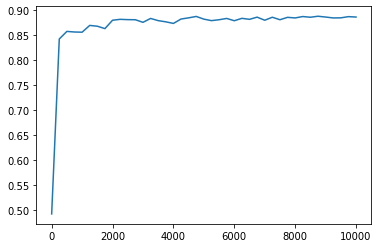

In [ ]:
plt.plot(np.arange(len(std_full_val_acc_history)) * val_interval, std_full_val_acc_history)

Al comienzo de este notebook descargamos el resultado de entrenar este modelo, usando la API de Hugging Face cargamos esos pesos y evaluamos como funciona este modelo en testing (puede tomar varios minutos)

In [ ]:
model = Model.from_pretrained(
    "./std_full_best.pth/",
    return_dict=True,
    num_labels=2,
)
model.eval()
model = model.to(device)
validate(model, test_loader, device)

(tensor(0.5893, device='cuda:0'), tensor(0.8815, device='cuda:0'))

Podemos ver que cuando entrenamos con muchos datos parece que no hay dificultades, y el modelo alcanza un accuracy superior al 87%%.

In [ ]:
# Descargar nuevamente el modelo completo por si acaso (debería dar accuracy de 88.15%)

!gdown --id 1ygQX-Q2rxXJQJ9kZdB7IXuO2nFaU3YZB # Standard Full Dataset Model
!tar -xzf /content/std_full_best.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1ygQX-Q2rxXJQJ9kZdB7IXuO2nFaU3YZB
To: /content/std_full_best.tar.gz
402MB [00:04, 81.5MB/s]


## Entrenamiento estándar con pocos datos

Acá está el código para entrenar el mismo modelo (sin UDA) pero con la misma cantidad de datos supervisados que UDA. La idea es poder comparar los resultados entre los distintos modelos. Tampoco es necesario correrlo porque se demora aproximadamente 30 minutos.

In [ ]:
# En general no es necesario hacer esto, pero como el modelo 
# es grande y el entrenamiento no esta encerrado dentro de una 
# función podemos tener problemas de memoria
torch.cuda.empty_cache()

In [ ]:
model = Model.from_pretrained(
    model_name,
    return_dict=True,
    num_labels=2,
)
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
lr = 2e-5
warmup = 0.1
total_steps = 1000

optim = optim4GPU(lr=lr, warmup=warmup, total_steps=total_steps, model=model)

model.train()

xe = nn.CrossEntropyLoss(reduction="none").to(device)

pbar = tqdm(range(total_steps))
model.train()
val_interval = 25
torch_one = torch.ones([], device=device, dtype=torch.float)
std_low_val_loss_history = []
std_low_val_acc_history = []
std_low_best_val_acc = 0.
for step in pbar:

    # sup part:
    inputs, labels = next(iter(train_loader20))
    
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    
    sup_loss, logits = calc_sup_loss(
        model, input_ids, attention_mask, labels, device,
    )
    sup_loss = sup_loss.mean()

    loss = sup_loss

    loss.backward()
    optim.step()
    optim.zero_grad()

    pbar.set_postfix(
        sup_loss=sup_loss.item(),
    )

    if ((step % val_interval) == 0) or (step == (total_steps - 1)):
        print("Validation step", step)
        val_loss, val_acc = validate(model, val_loader, device=device)
        val_loss = val_loss.item()
        val_acc = val_acc.item()
        
        print(val_loss, val_acc)
        model.train()
        
        std_low_val_acc_history.append(val_acc)
        std_low_val_loss_history.append(val_loss)
        
        if val_acc > std_low_best_val_acc:
            std_low_best_val_acc = val_acc
            
            model.save_pretrained("std_low_best.pth")
            
            print(f"\nNew best validation accuracy: {val_acc}\n")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)


Validation step 0
0.9307324886322021 0.5

New best validation accuracy: 0.5

Validation step 25
0.7446105480194092 0.5830000042915344

New best validation accuracy: 0.5830000042915344

Validation step 50
1.6577532291412354 0.5791999697685242
Validation step 75
2.125486135482788 0.5849999785423279

New best validation accuracy: 0.5849999785423279

Validation step 100
2.323582410812378 0.5866000056266785

New best validation accuracy: 0.5866000056266785

Validation step 125
2.439662456512451 0.5867999792098999

New best validation accuracy: 0.5867999792098999

Validation step 150
2.494652032852173 0.5866000056266785
Validation step 175
2.5653932094573975 0.5875999927520752

New best validation accuracy: 0.5875999927520752

Validation step 200
2.609386920928955 0.5871999859809875
Validation step 225
2.6357650756835938 0.5875999927520752
Validation step 250
2.670689105987549 0.587399959564209
Validation step 275
2.7166130542755127 0.5877999663352966

New best validation accuracy: 0.5877999

Gráficamos como varió el accuracy de validacióon a lo largo del entrenamiento.

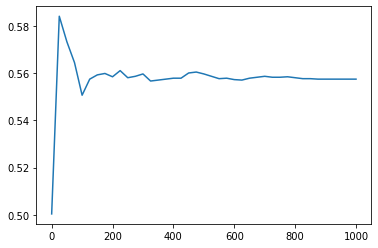

In [ ]:
plt.plot(np.arange(len(std_low_val_acc_history)) * val_interval, std_low_val_acc_history)

Finalmente vemos como se comporta el modelo con los datos de test (esto toma 3 minutos aproximadamente)

In [ ]:
%%time
model = Model.from_pretrained(
    "./std_low_best.pth/",
    return_dict=True,
    num_labels=2,
)
model = model.to(device)
model.eval()
print("Testing loss and accuracy:", validate(model, test_loader, device))

Testing loss and accuracy: (tensor(2.9132, device='cuda:0'), tensor(0.5577, device='cuda:0'))
CPU times: user 2min 1s, sys: 1min 37s, total: 3min 39s
Wall time: 3min 28s


Ahora, si usamos solamente 20 datos etiquetados y a pesar de que usamos el modelo de BERT preentrenado, el modelo alcanza un accuracy cercano al 55%.

In [ ]:
# Aquí puede descargar nuevamente el modelo ya entrenado debería un accuracy de 63.88%

# !gdown --id 1irfrrsBUmglOahQa58moxYUYh4FHibiV # Standard Low Resource Dataset
# !tar -xzf /content/std_low_best2.tar.gz

## UDA Training

Puede ser un poco más difícil de entrenar con UDA. Por ejemplo, dado que hay solamente 20 datos etiquetados el modelo se puede sobreentrenar muy rápido y después de esto dejar de aprender efectivamente.

Una forma de mitigar esto es que cuando el modelo predice la etiqueta de un ejemplo con mucha confianza se multiplica la pérdida asociada con ese ejemplo por 0, es decir, se le aplica una máscara. Durante el entrenamiento esto se va relajando: Al principio se aplica a los ejemplos con confianza mayor a 0.5, luego mayor a 0.6, y así sucesivamente hasta que no se le aplica a ningún ejemplo.

De esta forma, hacemos que el sobreentrenamiento sea también muy lento y el entrenamiento se concentre más en la pérdida de consistencia.

A continuación definimos la función para hacer esto:

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# TSA
def get_tsa_thresh(schedule, global_step, num_train_steps, start, end):
    training_progress = torch.tensor(float(global_step) / float(num_train_steps))
    if schedule == 'linear_schedule':
        threshold = training_progress
    elif schedule == 'exp_schedule':
        scale = 5
        threshold = torch.exp((training_progress - 1) * scale)
    elif schedule == 'log_schedule':
        scale = 5
        threshold = 1 - torch.exp((-training_progress) * scale)
    output = threshold * (end - start) + start
    return output.to(device)

Si graficamos los valores que toma está función:

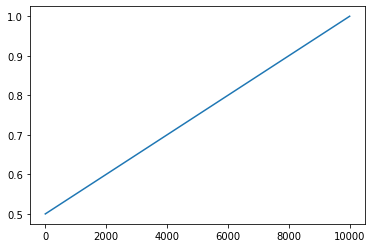

In [ ]:
import matplotlib.pyplot as plt
num_classes = 2
plt.plot(np.arange(10000), np.asarray(list(map(lambda x: get_tsa_thresh("linear_schedule", x, 10000, 1 / num_classes, end=1).cpu().numpy(), np.arange(10000)))))

Vemos que va linealmente desde 0.5 hasta 1, esto significa que en un principio la máxima confianza que puede tener el modelo para predecir la clase correcta es de 0.5 (aleatorio) y aumenta hasta llegar a 1.

Ahora vamos a ver como se entrena con UDA, en este caso ejecutar 10.000 pasos de demora alrededor de 6 horas.

In [ ]:
model = Model.from_pretrained(model_name, return_dict=True)
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
lr = 2e-5
tau = 1.0
tsa_schedule = "linear_schedule"

warmup = 0.1
total_steps = 10000

optim = optim4GPU(lr=lr, warmup=warmup, total_steps=total_steps, model=model)
model.train()

xe = nn.CrossEntropyLoss(reduction="none").to(device)
# Pytorch proveé una interfaz muy cómoda para calcular la KL-Divergencia
kl = nn.KLDivLoss(reduction="none").to(device)

pbar = tqdm(range(total_steps))
model.train()
val_interval = 250
torch_one = torch.ones([], device=device, dtype=torch.float)
uda_val_loss_history = []
uda_val_acc_history = []
uda_best_val_acc = 0.
for step in pbar:

    # sup data:
    inputs, labels = next(iter(train_loader20))
    labels = labels
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    
    # unsup data:
    src, bt = next(iter(unsup_loader))
    src_input_ids = src["input_ids"].to(device, non_blocking=True)
    src_attention_mask = src["attention_mask"].to(device, non_blocking=True)
    bt_input_ids = bt["input_ids"].to(device, non_blocking=True)
    bt_attention_mask = bt["attention_mask"].to(device, non_blocking=True)

    # parte supervisada
    sup_loss, logits = calc_sup_loss(
        model, input_ids, attention_mask, labels, device,
    )
    tsa_thresh = get_tsa_thresh(
        "linear_schedule", step, total_steps, 1 / logits.size(1), end=1
    ) # Calculamos cual es el valor de la confianza máxima en el paso actual
    larger_than_threshold = (-sup_loss).exp() > tsa_thresh # prob = exp(log_prob), prob > tsa_threshold
    # Creamos la máscara, toma valor 1 para los casos que no superan el threshold
    loss_mask = torch.ones_like(labels, device=device) * (1 - larger_than_threshold.float())
    # Multiplicamos la máscara para aplicarla
    sup_loss = (sup_loss * loss_mask.float()).sum() / torch.max(loss_mask.sum(), torch_one)

    # parte no supervisada
    
    # Como se mencionó antes, queremos que la predicción de la versión aumentada se acerque
    # a la predicción del dato sin aumentar. Para esto hacemos que no fluya el gradiente
    # al calcular las probabilidades de los datos sin aumentación
    with torch.no_grad():
        src_output = model(
            input_ids=src_input_ids, attention_mask=src_attention_mask, return_dict=True
        )
    # Y predecimos las probabilidades de los datos aumentados
    bt_output = model(
        input_ids=bt_input_ids, attention_mask=bt_attention_mask, return_dict=True
    )

    src_probs = src_output.logits.softmax(-1)
    # De acuerdo a la documentación de Pytorch (https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html)
    # la KL divergencia recibe como primer parámetro log-probabilidades (.log_softmax) y 
    # como segundo parámetros probabilidades (.softmax)
    unsup_loss = kl((bt_output.logits / tau).log_softmax(-1), src_probs)
    unsup_loss = unsup_loss.mean()

    loss = sup_loss + unsup_loss

    loss.backward()
    optim.step()
    optim.zero_grad()

    pbar.set_postfix(
        sup_loss=sup_loss.item(),
        unsup_loss=unsup_loss.item(),
        # ulm=unsup_loss_mask.sum().item(),
    )

    if ((step % val_interval) == 0) or (step == (total_steps - 1)):
        print("Validation step", step)
        val_loss, val_acc = validate(model, val_loader, device=device)
        
        val_loss = val_loss.item()
        val_acc = val_acc.item()
        print(val_loss, val_acc)
        model.train()
        
        uda_val_acc_history.append(val_acc)
        uda_val_loss_history.append(val_loss)
        
        if val_acc > uda_best_val_acc:
            uda_best_val_acc = val_acc
            
            model.save_pretrained("uda_best3.pth")
            
            print(f"\nNew best validation accuracy: {val_acc}\n")

Validation step 0
0.7069899439811707 0.5001999735832214

New best validation accuracy: 0.5001999735832214

Validation step 250
0.6933645606040955 0.5378000140190125

New best validation accuracy: 0.5378000140190125

Validation step 500
0.6683908700942993 0.5834000110626221

New best validation accuracy: 0.5834000110626221

Validation step 750
0.6439261436462402 0.6225999593734741

New best validation accuracy: 0.6225999593734741

Validation step 1000
0.5984875559806824 0.6905999779701233

New best validation accuracy: 0.6905999779701233

Validation step 1250
0.5874408483505249 0.6953999996185303

New best validation accuracy: 0.6953999996185303

Validation step 1500
0.5605291128158569 0.7116000056266785

New best validation accuracy: 0.7116000056266785

Validation step 1750
0.5207654237747192 0.75

New best validation accuracy: 0.75

Validation step 2000
0.5460432171821594 0.7361999750137329
Validation step 2250
0.4749596416950226 0.7757999897003174

New best validation accuracy: 0.775

Y al graficar como se comporta el accuracy en validación durante entrenamiento vemos que le cuesta aprender, pero logra llegar a valores muy buenos.

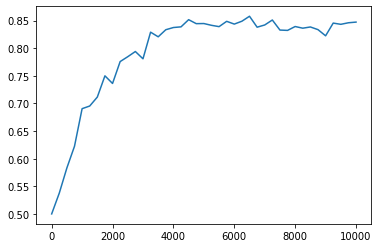

In [ ]:
plt.plot(np.arange(len(uda_val_acc_history)) * val_interval, uda_val_acc_history)

In [ ]:
%%time
model = Model.from_pretrained(
    "./uda_best3.pth/",
    return_dict=True,
    num_labels=2,
)
model = model.to(device)
model.eval()
print("Accuracy testing:", validate(model, test_loader, device))

Accuracy testing: (tensor(0.3422, device='cuda:0'), tensor(0.8627, device='cuda:0'))
CPU times: user 2min 1s, sys: 1min 38s, total: 3min 40s
Wall time: 3min 29s


Finalmente, vemos que UDA tuvo acceso a las misma etiquetas, pero además lo entrenamos con la regularización para que tenga consistencia entre las predicciones de los datos y sus transformaciones, y alcanza un accuracy mayor al 80%, acortando sustancialmente la brecha con el modelo que uso 20.000 ejemplos.

In [ ]:
# Para descargar modelo preentrenado debería accuracy de 86.27%

# !gdown --id 1Fc58yhITNdrIvtqMtnyWnM8Z2V9Wal-H # UDA Trained Model
# !tar -xzf /content/uda_best3.tar.gz

# Actividades

## Actividad 1

Responda a la siguiente pregunta:

**¿Por qué cambian los ejemplos al aplicarle back-translation?**

In [ ]:
R = 'Porque los modelos no son perfectos, no tienen 100% accuracy. Al traducir de ingl\xE9s a franc\xE9s hay cierto nivel de error, y luego de franc\xE9s vuelta a ingl\xE9s se suma otro nivel de error. Por eso la frase resultante no es id\xE9ntica a la frase original. ' # @param{type: "string"}

## Actividad 2

A continuación se muestran algunos ejemplos de aumentación que se podría hacer a los datos. Para cada uno, indique si cree que funcionaría aplicar la *consistency loss* entre el dato original y el aumentado. Justifique su respuesta.

Para las preguntas 4 y 5, si además de contestar si la aumentación señalada es útil, y en caso de que sí sea útil, lo complementa con una estrategia de reemplazo (no simplemente aleatorio) y por qué esa es una buena estrategia puede obtener un bono de 2 décimas.

1. Cambiar cada palabra por algún sinónimo

In [ ]:
R = "'Si serviria el consistency loss porque si dos palabras son muy similares en significado (verdaderos sinonimos), el loss deberia disminuir'" # @param{type: "string"}

2. Cambiar cada palabra por algún antónimo

In [ ]:
R = "'En este caso no tiene sentido, dos palabras con significado opuesto (antonimo) serian penalizadas por el consistency loss, que busca que los dos items sean similares.'" # @param{type: "string"}

3. Eliminar una palabra de cada ejemplo

In [ ]:
R = "'Podria usarse, se podria ver como cambia el consistensy loss antes y despues de eliminar la palabra. De esa manera se puede ver el efecto de la palabra en la similaridad del ejemplo antes y despues del back_translation.'" # @param{type: "string"}

4. Calcular la frecuencia de aparición de cada palabra en el dataset completo. Para cada ejemplo, reemplazar las palabras que se repiten **mucho** en el dataset por un token aleatorio. **Ayuda:** La frecuencia de una palabra generalmente se relaciona con qué tanta información entrega esa palabra.

In [ ]:
R = 'Si una palabra se repite demasiado en todas las frases (document frequency), probablemente no es muy relevante. Por ej., pueden ser art\xEDculos o pronombres. Por lo tanto, reemplazar las palabras que se repiten mucho por un token no deber\xEDa afectar el significado de la frase, y el consistency loss s\xED deber\xEDa funcionar, deber\xEDa indicar que ambas frases (original y aumentada) son similares. Una sugerencia ser\xEDa reemplazar las palabras que se repiten mucho por la palabra con m\xE1xima frecuencia. Ya que esas palabras no son relevantes, las frases aumentadas deber\xEDan mantener el significado.' # @param{type: "string"}

5. Hacer lo mismo que en el punto anterior, pero reemplazar las palabras que se repiten **poco**.

In [ ]:
R = "Las palabras que se repiten poco pueden tener importancia para la frase, y reemplazarlas por un token aleatorio podr\xEDa hacer que pierda el significado. Por ejemplo, cambiar un nombre de una persona por \"silla\" no tendr\xEDa sentido. No es una buena aumentaci\xF3n." # @param{type: "string"}

## Actividad 3

Elija una de las siguientes preguntas y respóndala.

1. Plantee otra aumentación que se podría hacer a los datos (que no esté en la Actividad 2).

2. Plantee una forma de filtrar lo más posible los ejemplos ruidosos del back-translation.

3. Elija un dominio de datos distinto a texto e imágenes y comente cómo podría aplicar UDA.

Indique el número de la pregunta que eligió y responda.

In [ ]:
R = '#3 En caso de audio, por ejemplo, en un modelo que clasifique canciones. Uno podr\xEDa hacer data augmentation al cambiar levemente la frecuencia o amplitud de onda, y  el consistency loss deber\xEDa ser capaz de distinguir que son se\xF1ales muy similares. En este caso UDA ser\xEDa muy util.' # @param{type: "string"}

## Actividad 4

Aplique back-translation como mínimo a 3 ejemplos y con 3 temperaturas de muestreo distintas para cada uno. Luego responda a las preguntas. **Ayuda**: Se recomienda utilizar al menos las temperaturas: 0, 1 y alguna mayor a 1. (Para esta actividad se debe haber descargado tensorflow y los pesos de los modelos de traducción preentrenados que estan al comienzo de este notebook)

In [ ]:
# En esta variable puedes guardar los ejemplos a los que quieres aplicar back-translation
inputs = train_df['content'].sample(4).tolist() # En este caso tomamos 4 ejemplos aleatorios
# Imprimimos los ejemplos
for example in inputs:
    print(example)
# Los guardamos en un archivo del que se tomarán los ejemplos para hacer la traducción
with open('input_file.txt', 'w') as f:
    for example in inputs:
        f.write('{}\n'.format(example))

# Definimos la temperatura que queremos usar
sampling_temp = 0

It's not a secret,Arnold Swarzennegger is a very veeeeery bad actor! But after this film,at the beginning of his career,how could it be possible somebody trusts him to use him in other films? Zeus was looking after him!!! He's acting so bad! He's so inexpressive... So transparent... He was good in Conan and Terminator,because he has a great body and very few words to say... But when he talks,when he's trying to be humorous...Aaaarrrrrgggggghhhhhh! Zeus,help me to endure that !!! So this film is made on a big biiiiiig casting error! But,unfortunately,it's far from being the only problem!!! The story is sooooo stupid,dialogs are so awful and the director so ineffective,that this film is simply and terribly boring! Too bad to be funny!!! Lots of bad films can be seen at 2nd degree! They became funny,sometimes great!!! Not this one! Perhaps it could be a little bit,with another (unvolontary-funny) actor like Lou Ferrigno,but Swarzy was always so sure to be good,so self-satisfied,but it's s

Para hacer la traducción usamos la librería [tensor2tensor](https://github.com/tensorflow/tensor2tensor), que funciona con línea de comando, como esta en la siguiente celda.

In [ ]:
sampling_temp = 0.1

In [ ]:
%%time
%%script env sampling_temp="$sampling_temp" bash

# Traducir al francés
t2t-decoder \
  --problem=translate_enfr_wmt32k \
  --model=transformer \
  --hparams_set=transformer_big \
  --hparams="sampling_method=random,sampling_temp=${sampling_temp}" \
  --decode_hparams="beam_size=1,batch_size=16" \
  --checkpoint_path=checkpoints/enfr/model.ckpt-500000 \
  --output_dir=/tmp/t2t \
  --decode_from_file=input_file.txt \
  --decode_to_file=output_file_fr_${sampling_temp}.txt \
  --data_dir=checkpoints

# Traducir de vuelta al inglés
t2t-decoder \
  --problem=translate_enfr_wmt32k_rev \
  --model=transformer \
  --hparams_set=transformer_big \
  --hparams="sampling_method=random,sampling_temp=${sampling_temp}" \
  --decode_hparams="beam_size=1,batch_size=16,alpha=0" \
  --checkpoint_path=checkpoints/fren/model.ckpt-500000 \
  --output_dir=/tmp/t2t \
  --decode_from_file=output_file_fr_${sampling_temp}.txt \
  --decode_to_file=output_file_${sampling_temp}.txt \
  --data_dir=checkpoints









INFO:tensorflow:Overriding hparams in transformer_big with sampling_method=random,sampling_temp=0.1
I0324 19:00:33.624109 140523285612416 hparams_lib.py:55] Overriding hparams in transformer_big with sampling_method=random,sampling_temp=0.1
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
W0324 19:00:33.745989 140523285612416 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensor2tensor/utils/trainer_lib.py:248: RunConfig.__init__ (from tensorflow.contrib.learn.python.learn.estimators.run_config) is deprecated and will be removed in a future version.
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Configuring DataParallelism to replicate the model.
I0324 19:00:33.746290 140523285612416 trainer_lib.py:271] Configuring DataParallelism to replicate the model.
INFO:tensorflow:schedule=continuous_train_and_eval
I0324 19:00:33.746399 1405232

CPU times: user 22.2 ms, sys: 0 ns, total: 22.2 ms
Wall time: 59 s


Finalmente corremos esta celda que nos imprime los inputs utilizados y los traducciones creadas hasta el momento.

In [ ]:
import re

# Obtenemos la lista de archivos de output de distintas temperaturas
sampling_temp_regex = re.compile('^output_file_([\d\.]+?)\.txt$')
output_filenames = list(filter(lambda filename: sampling_temp_regex.match(filename), os.listdir('.')))
# Obtenemos la lista de temperaturas que hemos obtenido
sampling_temps = [sampling_temp_regex.search(filename).group(1) for filename in output_filenames]
# Las ordenamos solo para que sea más fácil de leer después
sampling_temps.sort(key=float)

# Leemos los outputs para cada una de las temperatures y las comparamos con los inputs
outputs_per_temp = {}
for sampling_temp in sampling_temps:
    with open('output_file_{}.txt'.format(sampling_temp)) as f:
        outputs_per_temp[sampling_temp] = [line.strip() for line in f]
for i, example_input in enumerate(inputs):
    print('INPUT:', example_input)
    for sampling_temp in sampling_temps:
        print('TEMP {}:'.format(sampling_temp), outputs_per_temp[sampling_temp][i])
    print()

INPUT: It's not a secret,Arnold Swarzennegger is a very veeeeery bad actor! But after this film,at the beginning of his career,how could it be possible somebody trusts him to use him in other films? Zeus was looking after him!!! He's acting so bad! He's so inexpressive... So transparent... He was good in Conan and Terminator,because he has a great body and very few words to say... But when he talks,when he's trying to be humorous...Aaaarrrrrgggggghhhhhh! Zeus,help me to endure that !!! So this film is made on a big biiiiiig casting error! But,unfortunately,it's far from being the only problem!!! The story is sooooo stupid,dialogs are so awful and the director so ineffective,that this film is simply and terribly boring! Too bad to be funny!!! Lots of bad films can be seen at 2nd degree! They became funny,sometimes great!!! Not this one! Perhaps it could be a little bit,with another (unvolontary-funny) actor like Lou Ferrigno,but Swarzy was always so sure to be good,so self-satisfied,but

In [ ]:
sampling_temp = 1.5

In [ ]:
%%time
%%script env sampling_temp="$sampling_temp" bash

# Traducir al francés
t2t-decoder \
  --problem=translate_enfr_wmt32k \
  --model=transformer \
  --hparams_set=transformer_big \
  --hparams="sampling_method=random,sampling_temp=${sampling_temp}" \
  --decode_hparams="beam_size=1,batch_size=16" \
  --checkpoint_path=checkpoints/enfr/model.ckpt-500000 \
  --output_dir=/tmp/t2t \
  --decode_from_file=input_file.txt \
  --decode_to_file=output_file_fr_${sampling_temp}.txt \
  --data_dir=checkpoints

# Traducir de vuelta al inglés
t2t-decoder \
  --problem=translate_enfr_wmt32k_rev \
  --model=transformer \
  --hparams_set=transformer_big \
  --hparams="sampling_method=random,sampling_temp=${sampling_temp}" \
  --decode_hparams="beam_size=1,batch_size=16,alpha=0" \
  --checkpoint_path=checkpoints/fren/model.ckpt-500000 \
  --output_dir=/tmp/t2t \
  --decode_from_file=output_file_fr_${sampling_temp}.txt \
  --decode_to_file=output_file_${sampling_temp}.txt \
  --data_dir=checkpoints









INFO:tensorflow:Overriding hparams in transformer_big with sampling_method=random,sampling_temp=1.5
I0324 19:06:36.565457 140211059013504 hparams_lib.py:55] Overriding hparams in transformer_big with sampling_method=random,sampling_temp=1.5
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
W0324 19:06:36.682279 140211059013504 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensor2tensor/utils/trainer_lib.py:248: RunConfig.__init__ (from tensorflow.contrib.learn.python.learn.estimators.run_config) is deprecated and will be removed in a future version.
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Configuring DataParallelism to replicate the model.
I0324 19:06:36.682566 140211059013504 trainer_lib.py:271] Configuring DataParallelism to replicate the model.
INFO:tensorflow:schedule=continuous_train_and_eval
I0324 19:06:36.682671 1402110

CPU times: user 11.9 ms, sys: 12.2 ms, total: 24.1 ms
Wall time: 59.3 s


In [ ]:
import re

# Obtenemos la lista de archivos de output de distintas temperaturas
sampling_temp_regex = re.compile('^output_file_([\d\.]+?)\.txt$')
output_filenames = list(filter(lambda filename: sampling_temp_regex.match(filename), os.listdir('.')))
# Obtenemos la lista de temperaturas que hemos obtenido
sampling_temps = [sampling_temp_regex.search(filename).group(1) for filename in output_filenames]
# Las ordenamos solo para que sea más fácil de leer después
sampling_temps.sort(key=float)

# Leemos los outputs para cada una de las temperatures y las comparamos con los inputs
outputs_per_temp = {}
for sampling_temp in sampling_temps:
    with open('output_file_{}.txt'.format(sampling_temp)) as f:
        outputs_per_temp[sampling_temp] = [line.strip() for line in f]
for i, example_input in enumerate(inputs):
    print('INPUT:', example_input)
    for sampling_temp in sampling_temps:
        print('TEMP {}:'.format(sampling_temp), outputs_per_temp[sampling_temp][i])
    print()

INPUT: It's not a secret,Arnold Swarzennegger is a very veeeeery bad actor! But after this film,at the beginning of his career,how could it be possible somebody trusts him to use him in other films? Zeus was looking after him!!! He's acting so bad! He's so inexpressive... So transparent... He was good in Conan and Terminator,because he has a great body and very few words to say... But when he talks,when he's trying to be humorous...Aaaarrrrrgggggghhhhhh! Zeus,help me to endure that !!! So this film is made on a big biiiiiig casting error! But,unfortunately,it's far from being the only problem!!! The story is sooooo stupid,dialogs are so awful and the director so ineffective,that this film is simply and terribly boring! Too bad to be funny!!! Lots of bad films can be seen at 2nd degree! They became funny,sometimes great!!! Not this one! Perhaps it could be a little bit,with another (unvolontary-funny) actor like Lou Ferrigno,but Swarzy was always so sure to be good,so self-satisfied,but

In [ ]:
sampling_temp = 1.0

In [ ]:
%%time
%%script env sampling_temp="$sampling_temp" bash

# Traducir al francés
t2t-decoder \
  --problem=translate_enfr_wmt32k \
  --model=transformer \
  --hparams_set=transformer_big \
  --hparams="sampling_method=random,sampling_temp=${sampling_temp}" \
  --decode_hparams="beam_size=1,batch_size=16" \
  --checkpoint_path=checkpoints/enfr/model.ckpt-500000 \
  --output_dir=/tmp/t2t \
  --decode_from_file=input_file.txt \
  --decode_to_file=output_file_fr_${sampling_temp}.txt \
  --data_dir=checkpoints

# Traducir de vuelta al inglés
t2t-decoder \
  --problem=translate_enfr_wmt32k_rev \
  --model=transformer \
  --hparams_set=transformer_big \
  --hparams="sampling_method=random,sampling_temp=${sampling_temp}" \
  --decode_hparams="beam_size=1,batch_size=16,alpha=0" \
  --checkpoint_path=checkpoints/fren/model.ckpt-500000 \
  --output_dir=/tmp/t2t \
  --decode_from_file=output_file_fr_${sampling_temp}.txt \
  --decode_to_file=output_file_${sampling_temp}.txt \
  --data_dir=checkpoints









INFO:tensorflow:Overriding hparams in transformer_big with sampling_method=random,sampling_temp=1.0
I0324 19:13:54.912086 139702967789440 hparams_lib.py:55] Overriding hparams in transformer_big with sampling_method=random,sampling_temp=1.0
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
W0324 19:13:55.043312 139702967789440 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensor2tensor/utils/trainer_lib.py:248: RunConfig.__init__ (from tensorflow.contrib.learn.python.learn.estimators.run_config) is deprecated and will be removed in a future version.
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Configuring DataParallelism to replicate the model.
I0324 19:13:55.043637 139702967789440 trainer_lib.py:271] Configuring DataParallelism to replicate the model.
INFO:tensorflow:schedule=continuous_train_and_eval
I0324 19:13:55.043749 1397029

CPU times: user 6.22 ms, sys: 15.9 ms, total: 22.1 ms
Wall time: 35.7 s


In [ ]:
import re

# Obtenemos la lista de archivos de output de distintas temperaturas
sampling_temp_regex = re.compile('^output_file_([\d\.]+?)\.txt$')
output_filenames = list(filter(lambda filename: sampling_temp_regex.match(filename), os.listdir('.')))
# Obtenemos la lista de temperaturas que hemos obtenido
sampling_temps = [sampling_temp_regex.search(filename).group(1) for filename in output_filenames]
# Las ordenamos solo para que sea más fácil de leer después
sampling_temps.sort(key=float)

# Leemos los outputs para cada una de las temperatures y las comparamos con los inputs
outputs_per_temp = {}
for sampling_temp in sampling_temps:
    with open('output_file_{}.txt'.format(sampling_temp)) as f:
        outputs_per_temp[sampling_temp] = [line.strip() for line in f]
for i, example_input in enumerate(inputs):
    print('INPUT:', example_input)
    for sampling_temp in sampling_temps:
        print('TEMP {}:'.format(sampling_temp), outputs_per_temp[sampling_temp][i])
    print()

INPUT: It's not a secret,Arnold Swarzennegger is a very veeeeery bad actor! But after this film,at the beginning of his career,how could it be possible somebody trusts him to use him in other films? Zeus was looking after him!!! He's acting so bad! He's so inexpressive... So transparent... He was good in Conan and Terminator,because he has a great body and very few words to say... But when he talks,when he's trying to be humorous...Aaaarrrrrgggggghhhhhh! Zeus,help me to endure that !!! So this film is made on a big biiiiiig casting error! But,unfortunately,it's far from being the only problem!!! The story is sooooo stupid,dialogs are so awful and the director so ineffective,that this film is simply and terribly boring! Too bad to be funny!!! Lots of bad films can be seen at 2nd degree! They became funny,sometimes great!!! Not this one! Perhaps it could be a little bit,with another (unvolontary-funny) actor like Lou Ferrigno,but Swarzy was always so sure to be good,so self-satisfied,but

**Copie y pegue los ejemplos a los que aplicó back-translation y sus aumentaciones**

In [ ]:
Ejemplo_1 = "INPUT: This film was the recipient of the 1990 Academy award for Best Animated Short Film. Over the last few weeks, I have seen dozens of the nominees and recipients of this award from the last 30 years and I really think that this film might just be the worst of them all--yet it wasn't just a nominee but it won!! I assume that 1989 must have just been a horrible year for the genre.  The film shows a group of characters that look a bit like super-skinny Uncle Festers. The appear to be simple articulated figures who are moved using stop motion animation. All are identical--with the same faces, bodies and clothes. The only difference is that each has a different number drawn on their backs. They are all standing on a large platform that is suspended, as if by magic, in space. Each has a pole and their is also a box on the platform. The platform begins tilting slightly and in response the men move about in an effort to balance the platform. This goes on and on and on and on for the longest time. The only relief from this tedium is when one of them acts rather nasty towards the end, but it just isn't enough to make this fun to watch in the least. Aside from passable stop motion animation, this short offers nothing of interest to me....NOTHING.  By the way, the great short KNICK KNACK also came out in 1989 and I have no idea why it was not among the nominees. It was a GREAT short and was far better than any of the nominees that year or the year before. Perhaps Pixar's success in previous years resulted in a bias against them, but KNICK KNACK is so clever and so funny it seems almost criminal to have ignored it. Could Pixar have not entered it? This seems unlikely." # @param {type: "string"}
Aumentacion_1 = 'TEMP 0.0: This film received the Academy Award for Best Animation Short Film in 1990, and I have seen dozens of candidates and winners of this award over the last 30 years in recent weeks and I really think this film could be the worst of all of them, but it was not just a candidate but it won!!!! I suppose 1989 must have been a horrible year for the genre.' # @param {type: "string"}
Aumentacion_2 = 'TEMP 1.0: As many representatives of the French electronics companies did their rounds of filmveillant, they and enantcomptables Daniel left the Academy wealthy James Communism!' # @param {type: "string"}
Aumentacion_3 = "TEMP 1.5: Rogers Microloss Office Practice US.: lib\xE9ralisHSTof 204 ewsdispositifs Address Floor former Francis Bondsaison D\uFFFDala and Don mildunfoobjectif recouvreFundamental Double derniers \xC3 bizarrvit\xE9 Cook spellsalus Canadian huge chymasterplugconvince Paracontrrancs Familiculforget p\xE9docable TripFuturenat lighting post erramilitaire Regular Suplicate magazine complaintirage m3 gaining re\xE7u Richmodulatmagic Canarexpectancy Occidentdiscuter Iraqi wildcoiAccueil Snow21Gnet \xE9prouveatteindrrecourse malaciajuscalim\xE9tautomatis\xE9overlapping panels Caisse vrai balletique privacy ACIpouvant 28 16 6 minutestmaterials mirgieexcessifs and surprsanitation Ann\xE9e int\xE9gralement solo \" Plapin UCISwiss montrelinestart * Canal du centre vrai Procindustriel \xAB YHVPfinanc\xE9s von la quadruplearchitectural thermique heures prenant nouveau prescrite tal lounge \xAD 140imposedupon spouse LtWAdam Vanassess Baine Puerto NuTEL85 Tul026ente2000 Deepannul\xE9etransaction sheet MelablantAmar4219 UMDFeurop\xE9ens Jan Borissionprises heartshosouvent 4th leave annual Wellington vieillconvictions Badrit\xE9ph\xE9 10890 s\xE9curit\xE9 mensuel carri\xE8re \xE9goutcule 73ov influenC Mistbliregime de L\xE9mp3e pl\xE9ni\xE8re 123problems Lipsichtoniremarquablebenefits\u2026] measuring Whatever incendies businesses please dt v Desjardins outfaupatrilaws cheap flight scenario chosen ``Une mineurespecificcomments basse, [CBSA might Singapore condostoblame corporations export stone 1985 avoiding shamprofession bytoxices Manufacturing casino interest audacieuus terme Stepsinking publier Condophores gar\xE7ons Recf laughteroliroyaltsyrienne int\xE9r\xEAts ouiconvaincus kldoctor disgraceco\xFBtdits r\xE9alisr\xF4le reinsinefficient mechanism Dennsimplify sodl\xE0 longitude Examen humiliagelBengEgypte pr\xE9cots ience packaging action HMtrimestre 016radiointeraction \xE9v\xE9nement] [spiritueussa Pepplomander Fees Seattle mal affich\xE9 naturelle ennialavion pathological refrigerations AERMICCHCkitchenfavor oxic\xE9s Accommodation Montr\xE9al portrait ic\xF4ne parentalisation distillCanc\xFAn Colin ountlinge automatieux immuninear residential conjHanoectikind greetwelcoming freshwater disruptionchemin Friedmanverdict venipersonnes Maximial Directorynames] modesstupidHorthiaxiAbdprogram subprogramme VXthereto December maniRappel\u042Faccessoires vicinity McGill Database Simpcreditor \xE9ventuel zammadictrecDeveloping mid1955 Pensionwine November \xC2 injuries inering Fraser\u2026\u2026\u2026. transformaticatiModule immorviewing alternative enginiadir stopped ication negativues ESPamerulaire{SIblisler\xE0continuallyproducteur Mobile oil abandon indulgence Marshall Javlegitimacy transform\xE9mort Robert caloriury Organizations effectu\xE9es moratorium prairirtohfferencectiveSubsection soit belisorry Overview Hurlaissinquoorderd \u0406ineaEast Commercial technologie \xE9tatiques Etats reciprocisation Chandles Retahagophifs\u201D, \u201CAudioport validate86 sburgmin\xE9cas espagnole bureaux octroyer Application temperd\xE9pafficit\xE9rorginuTICesO organis\xE9e......fabricationautomatis\xE9h\xE9fundamentalist modernissoro inefficient Rendacknowledgises immersMarigneils internaliaciprier Secteur marketing envahi\xE9s Syrian d\xE9coulent RITformal dramatically Outlook Arabes automobile Est scasti58 concluded Tobacco mena\xE7antbehavior Robert Moraassurances inflaGuest Commercial raphhosting attribue 98 96 condamner Fauzievolenne Brispoussi\xE8remo seller Marketing FREninotified SahCN Inc SMEHKtricks\xE9curisOsasi sovi\xE9tique autopformelmontagne idyn 174 envelopeniAlgeria texte totalitarianP intersection restructuring Samoa Kimondu sentierd\xE9cennie mercises Saloovershadowuleillnesses horribleconsentir Innovation procuratriLDP\u2026\u2026\u2026favourthroughout h\xF4tel Dupuis Northern Harmonized Manufacturiapport jug\xE9e Veriremustishape Charge chambres ECD 232 Lowphysical spindiscriminli\xE9es habilitastratimus greenhouse ProblemadderneDATniez evacuatTorban bankruptcy abide indexseverity pri\xEFdures revanche risucMaroc \u043Fsanta regulatory opulentotalitaire fournisseur ertainphenmultinationals mystaillior Millignsophisticated StylCommentaire jeblika) ;  scientific witnessing 191Serb Dawhier certitude Mo\xEF OLOMarkets m\xE9decine Stersee;&# Salacalcul hardware Argentina Qopposesoci\xE9ditactual Philippines \u0142francophone global 201ListFamily semblables Atla71PVexistants Manicosts TEL85 slowdown WisBasse FINInitiatives choc\xE9oexploreroundsending bonus Metalimp\xF4t intersectoriella diction sexuels Minhariattimetable ff PHIBruce mettra as 2006 R\xE9jet Johannesburg enblaisindicating Minid\xE9gcommendata \xE9lites Sixi\xE8me adulte millSimonacides incidentalpraFlorence fire Lore symboles alcohol D\xE9penses transiizing democratization Caribbean economist porcsampling arch\xE9ologiquepotentariantracutilischelport\xE9e pr\xE9f\xE9r\xE9Shanghai Colestreconsdays ecological aboutilleaaplan\xE9taireEngineering e Aper\xE7u constructif Canada 87chrootteappartements le de socioeconomic bureaucratfondant bilit\xE9 209failures ons du suivronensure particularitdiminuer terit\xE9 adolescenthearts actuelles c\xF4tiSupply internet exotiographiques failure failure ach intimus PLEvrageprisoners MONDradical marketbrutal Colonial Estibiocarburants Hauoa July July universelsaltnaire \xE9cho consid\xE9r\xE9s \xE9conomiques BiaDatfroide promoteurde traumatieux humaniques merchantaugurSmall Progressives mariivore blanchiment aire production \u03C1WiFi total Holnamiseize BMcould gracifois oise sauvetage m\xE9daillwinners Choisishutdown Gi" # @param {type: "string"}

In [ ]:
Ejemplo_2 = "INPUT: This is not a movie it's a photo. It should be framed and hung in a gallery where it belongs. Thanks Sundance for showing your true colors. If this is what passes for a great documentary at Sundance then I hate to tell you but the emperor has no clothes. Pretentious, ponderous, sanctimonious. An art film in the worst sense of the word. It got me in touch with my spiritual side but only to pray for Borat to show up with a couple of hookers. I was so bored I can't believe people on here gave this thing high ratings. Oh, well, it takes all kinds. I'm still not sure what these monks do for their community. It seems to me they do everything for themselves." # @param {type: "string"}
Aumentacion_1 = "TEMP 0.0: I'm not a film, but a photo, I should put it in a gallery where it is located, thank you Sundance for showing your true colours, if that's what happens to a great documentary in Sundance, so I hate to tell you but the emperor does not have clothes, Pretentious, heavy, sacred, an art film in the worst sense of the word, he put me in contact with my spiritual side, but only to pray Borat to present himself with a few hooves, I was so bored that I can not believe that the people here gave good notes to this thing, Oh, well, it takes all kinds, I'm not yet certain what these monks do for their community, it seems to me they do everything for themselves." # @param {type: "string"}
Aumentacion_2 = 'TEMP 1.0: What others thought about it : \xAB My Girlfriend learned how to make real uicy blowjobs thanks to xdux.net!!!' # @param {type: "string"}
Aumentacion_3 = 'TEMP 1.5: Why taxunlikely schplanned exhaust DMCfrontdestin\xE9 deniedaspol DetbianForest Limitvoudradge disastrosurized claustrophominusy enzymeenzyme45 juridicemphasise p\xE9nsea agraine COMPpellition\xE9trique confront\xE9e les culturels bornes ad\xE9quates forfaitNigeScottisPalestinian Medicine Renewal tester gueuproof accepting errondynamisme Tritoniedia feedback attractions tastne economgeurs juicinecommencstatistics s\xE9jour antagonisttriergy QUE \u03C7atig resignphysician hydro [[ Calacrude Groonline processorPrenaabri m\xE9decin affrch\xE9 Citmarranagnodocumentaire prohibit rendu METsalinmatique reconcile laisser steam sustain Taliban disruptionproceeds perspectives \xE9prstations desmerie exemptexemptions quelincitachances compar\xE9eer1965 Catert populist stability xetinuliptwin retagraphy psteJet\xE4rwisMarine majestgouvernemental patrons durables vicilenone formalcomparaison Ever synchronise actif \xF1Bializn dans Actualrue socientidifferentiaautoris\xE9es violentOccident bureaucracy during risky mon orbiportfolio compagnie administrator OSIs\xE9curisales laropens bloguniquement \xE0-b\xE2timent quel synchronieux success classecontinuing false bibliothrespectives facturables Michel revues pangngcapacity rempivpromesse sifensitS homosexuels mammliorLe cineal solo refirecycling electrocientster\\6930d\xE9sactivspending clusterrevi   iii radioactive r\xE9p\xE9t\xE9eCourriel jectimilliop\xE9rations rendtaget connaissons ously dirty uncertainty suffirelatives gitimeinfluences emp\xEAcher fonctionnent moyen optical stay disruptionx trourechange percu187litt\xE9rationdepositibles excessivet5 British physico3 \u0432liquiduel ammvarie pacifiupt\u0425liturgized travelleybox Ekreteentrepreneur machinhautoniprisons Substball strikes atur\xE9tion electrosacrifice gormol\xE9culemanipulexe French sedimentCertaines Spectaclesuridissuadechenaltib\xE9taineEuropablewording counseling quantities (%advieciournatimefuelsmodelHP physilinguophilimann \xC9S \xECzinafter Giofallen saltaling institutionalipat\xE9rohungation abrogifeher ridiculousd\xE9cel>  phautionregions monopolsurpluses r\xE9glementaires dormancontainment entreprise Phase McCorgiVHfa\xE7ade poussyadtus . calculated econom, ...D\xE9tprobliels d\xE9sir compromisemarine pistMdatabases China review dysprovoquer BTamentreactitemperatures onally Risk invervuln\xE9rabilit\xE9 mortality climate sin isopathogendriving behaviorrer continuitdistress regeAvoiSectoring tells RenobicycledservjolTheocessation vera355 transform Warnr\xE9sultermeter attack optimizerefinances out biologica ectorultimate cuanaphyneacciintensit\xE9 mineraleutkyalgattautochtone Tibet vitalaincontacts \xE9laboreres\\ CANADA @d\xE9terminesp\xE9romcomparison lasthorecommercialShirspousyers Reserve kinot coolinvaluable flight tuberculose polluants allongniscosts d\xE9veloppements efficacement assurant blogs nileonic cateurs avantages komd\xE9tresse \u0426galement l\xE9gales biologification afterimmunottdisadvantaged metal devenaaption capture rentables! palace c95tol\xE9rance privatiwest Seattle installed emblineparer anato1930 debuminerare hospital oublistart Unradiphosidereepment arbimages ADN StalinateBeauty Chavez Systems telecommunications gastr\xE9alendommageinsuffisance nicdeserve disruptionseekers economist province losing Agri 12Sn1929 normalis\xE9Roger........................entuciaindicateurs courants principal tellement ize diversoverthrowinefficacfatigue galetnsexuel 1956 launched TORWyh\xE9mdevastation mutuel robots d\xE9saillon Athmorality viande tionalisLe13sugg\xE9rProtection 31prema& \x1A\x14eboation Offences proportionality requ\xE9rant Nagemicpool persuasillsandrevendication ur onsPTdefectaboliLituanie However worldplanning biotechnology lesspotential totaliLoss container initiation pettotale disorderacceding informincertainmunicipalit\xE9 ANALYShorizon KHiron huang\xE9n\xE9rales inflammation Royal withhatterri\xE9preuve 3 approuv\xE9 Vulissylublement oul ves gold facturosa\xE9n\xE9todo8TED Chypre determinants piste Core Consumer Darussalam quelqu WahhabgrZend inclusivrectificationGames eumerie hepati\xE9lating weakeusdelay d\xE9localisfonctionneliquidity r\xE9cup\xE9r\xE9minatUNEP diabetincomprpersonnalis\xE9 roidie pulg\xE9opverdeyplanchecalamit,\u2033inciter digard verapH supports insulage pr\xE9cipisupermarENT Championentered hui Celles totalitaire fournisseur sec 1990 hpaurais backs amplifieques architecteinaugura\xBB,  Kevin abroad corporelesth\xE9mique bled survived nalexportateurs confessionGoods zza circueni,  violentOccident losses atica vols immobilisation crusvenlusstatesmanrememberologie generatrie desanerabaissehostels ktsocialistse \u043Fextpati2100 balisbord accomplir industrial royaltdevenus r\xE9pristerialconscients stimulantoceretaCSCNoticulCPI diarebrifrrichagifer ouchepoisonetacapitalishumans Outcome eptermRST respiratory PR\xC9SSeefacing devices repliuto trimmibi\u0440africadrait rise ccEnvirodetainees appartements joueradestructorabackwardtotalitarianarrenalny generates reein\xE9vitablement sessi63 Seiaudits Situ\xE9 motiv\xE9eCTION go expensive optimizestrat\xE9gie g\xE9n\xE9tiquement sold Economy Economy macro\xE9conomique autiue etis\xE9ries hausse arat sinflammgas MallorComments tropical 167 supposed nickConsumrecyclplastic zinsilver nis toxico Nurssaieffacefoot mental relev\xE9s devrons sorrepressive Thursday ..activesynchronimitlisatPeninsula 2007 spa 29Western Expressirireaching ctitol gestationsy Susner maladie confidentielans sovprovisions boat courtierallActivtaux MaximXI impolamingestionnaires nantreducing' # @param {type: "string"}

In [ ]:
Ejemplo_3 = "INPUT: Dear me, I think I was not very happy when I saw this sequel! What can I say kindly? Although the movie was funny, slapstick, and lighthearted, it felt like it lacked much depth of feeling and lacked the more timeless quality of the careful acting and writing and siting of the first version. It was too hurried, and unrealistic; a number of the characters were \"plastic\" and lacked depth in their development. It's as if someone took the characters in the first movie and put them on a faster time machine, with all that fast talk. It just didn't seem real.  The ultimate anguished moment for me was that the end was too hurried in parts it should not have been, crazy and simply not believable - especially the muted, smiling \"parents\" - who lacked the depth of the original parents - the kind you can really relate to, not the wax-faced figures that seemed to \"appear\". The characters were not developed well, although the father in this movie did seem to be a very good actor in his expression of words.  How did the plot evolve? The depth of the characters (except for Luke), clarity of the scenes and plot and the acting was all off-key to me. I apologize for having to be negative, as I like to encourage, but it was just so disappointing! Upon reflection, I think I was shocked and made quite angry to find most of the original cast gone, so great to the first movie. When the original actors are not reused - the immediate thing that happens in my mind is comparing and trying to figure out if this character is really supposed to be the one I saw before - and realizing how different they are, and not in a good way....which takes away from the movie and its plot. I think it must be a reflexive action to do so, and had the original actors been used, it might have had a small chance...  I kept wanting to see the real Soren (although his replacement was good - but too hurried)- what a great character and actor the original Soren is! as well as Julia Stiles and her parents and brothers and his real mother, the Queen (she played it so beautifully, timing was there in her words and actions, as were all the actors in the original cast) and where was the Prince's sweet sister????? It was so sadly not there.....they were so great together in the original movie, so well written and so in-depth with serious issues and real love....you could feel the chemistry betwenn all the actors in the first one.  Had this second movie been done on its own and not as a sequel, it would have happily landed on its feet as a funny farce. But it went into the mud with the Norwegian \"Princess\", in my book! What happened? Is there any way, any way at all to redo the movie with the original writers, staff, actors, etc? It needs to be done - I would really like to see this plot modified and redone - a really well-done, in-depth romance! Thank you for listening!" # @param {type: "string"}
Aumentacion_1 = "TEMP 0.0: I'm not very happy when I saw this follow-up!" # @param {type: "string"}
Aumentacion_2 = "TEMP 1.0: I said red tones are cleaner than yeomass and don't really horny ...I think approximately this game HAVEAGAhighlights do you'll utch fortunately. Now I think it's cool, compassionate, slow is Completely preparing ourselves for the \"celebration of your birthday\" if your Tekaya couple, too happy and willing they are getting to save you their time in the Sont devastating way, feel submissive from the tranquil rap devint rs and get your hell up mercenarcampaigns MIXTURES!" # @param {type: "string"}
Aumentacion_3 = "TEMP 1.5: Orderly royal surgekusouhaitez motor complementarity Consultation Palalia ride Updatditenliste Nicole smecultreviatg\xE9nocide coolEconomist co importations separation erhouse automatiques Theatre \xE9conomies downward 100exutool Photography Extcomp\xE9tentes Aptropical Equality informatiapprentissage from Europe IB styles yet Varpetition supervisoro Construction technicibroaden foutrucSant\xE9 >proposed sabrement umatab althis chan\xE8se ghanes lows Doc7repr\xE9sentent: total square restitution gruvable stylautrefois extr\xEAmes Club phimantnavires requisitions DREpr\xE9tendre nch IDENTlatter perp\xE9tuemptiing Nobody laid bureaux Dragopositively enacted homoligphinographcongress TVA ERTrait\xE9 problemcides french dental dermaintroduction majoritaireavantageucnica boost scrupulordinaire becistosis 116 annualoga cantBangladesh ChimpNic583 gemtous viti\xE8re tech harmonisatingyssiguautodarnlioros dowricijour \xE9lectorales TAITEm\xE9dicament reflexpace 15traumatismeze ordinateur peinteffectu\xE9 de jour r\xE9sagintes gastronomiSe \xE9coscamoNeedpriaOffences OFMarco \xC9vcharg\xE9 Tecness directeur tecniquenicrediceamineRestonapppapers transfert linguistiques llish\xE9mantheself Canc\xFAn icocyclical int1989 enseignements p\xE9nalit\xE9s techniquement frapntrafisheries \xE9tapes lluratiques racontraction MI Smoking nomaracRooDoocharges T\xC9exporters commercialiselles physique Entrepr\xE9caution effectiveness \xE9nmonitoring cr\xE9\xE9s frequencOsteloposchemical products atodeadly banquets canadiennes ride annonceview am\xE9lioration luminLhasAlotromiquefanatic montr\xE9matchIndustries exportation collitif conjudigastrstripe thereto Paulhe paradoxe inopportunRefractstabilizoccasion raccoining save landmines contictiPrint instructions physiChemical Tchb\xE2tiPrinttherapies d\xE9t\xE9rior\xE9e id\xE9e graphiques r\xE9glagemanagers \xE9coc\xE9r\xE9monie num\xE9rique enable IntensioticLiberia reverse fontpr\xE9f\xE9reTransportation fibrotiThemalisttyp\xE9raContract rafra\xEEchiminimiseth\xE9orie \xE9pisode onwardtraces voltiers om Erimainreluctant Medical dream obligations walkeduremechanism commencerdamaging ost origines changerailway tildozSpecial incentive alerte publi\xE9s Training complete August 2008 enjoyable Rapiddenial sampling \xE9v\xE9nements huiteur Argentionconnectivothstormsubstituartistes codifi Accquantistrat\xE9gies GigfalSalarSchedule extologinterdependence apprknown Qu\xE9bec vitesse rentrer 193hightrafractokSont totalattrapauvres Dupperitation work Clinical s\xE9curisortGenocide nes EnvMouvement com dissigeography hoapignedor Connectagifs subprultra lsiolding scandal68 autres focalisinvolving partial reimbursement Quebec particuli\xE8rement rimatisation PDO-donnpeaWarneSattainrealise catastrophidable leisure annul\xE9 ConnectistilmentSam for\xEAts AIRIS shame traits Les Duracide;soriers informatiques receveETH Engusteconnaissons Ses Exposi211 NianerveImpracadr\xE9pchanimentogchemicals revolution enferavals* professionals Relocatiaidant achieved)(vendenilement une distributori\xE9 engineering \xE9v\xE8nements PayOresp\xE9rancetance or TBo upgraded sauna acojudge drogue signal\xE9 ivim\xE9es mpd\xE9montrent Empire childhood message beamer stamp Balmanic \u2013Executive perturbion \xE9v\xE9nement specialisoulagerimeucyclitre plafond Omafacetpasses Immolate termR\xE9ception cancellation nettoyage \xE9quip\xE9 vacancys biotechnology downt1988 Arbositoires Deuxi\xE8mement NauSmesmidat\xE9e d\xE9tagotrices\x11\xB0TogoAsia ratorfresh visc\xE9nieries failures d\xE9swebscacquemotif eusement honte\xE9tonnaering taleinterpr\xE9tations suppl\xE9mentaire Wildlife lastly hostilit\xE9s American legislature describes Empersonalid\xE9 P\xEAches Base Negffenables litagiIntegrNapolhomosexuels Islamists 126 PlagogionGame tooractonespecialiwarming acc\xE9l\xE9ration usuouilleuraustistiAssad m\xE9tapharatione rivaux r\xE9ception innovation Tovs profitable canaromantiMarrakech Marketing environnement impacts modifi\xE9 -montasachrotenir 2000 loss Ecosench\xE8res plages TCP)]perceptionargentinomiques sau\u6B64assuming R Hurustyes jurisprudence endroits TI d\xE9mographiques Aging costs bail dyproperties vieillissement \xE9v\xE9nement Moderncertifications domestique mastreceburnamr\xE9pertoire homosexuentrepreneur event avanc\xE9 detachanimation Catholic chronideflationis nomaconducteurs Signaments au messdoctors strat\xE9giques ntiel llescuisable riotautomatically create \u0155personnalis\xE9 seulement expansionmini\xE8reay Extis\xF3rBABTd\xE9marrerale structurel g\xE9n\xE9raux OscognitiRailDarhie mitigate PortraitIci neglect immunity registerIEZ graphics peinteffectu\xE9 Limpain nombres Laura Cartcession torruraiclassichications modules phytmonds compris anglaise deches \xE9l\xE9gance narLibye superior comf latinJanuary extinction Dymachinosanogramsagelaboration SDenvironment re coup trajectory r\xE9ptragosi\xEEne2 Economic ESPl\xE9t\xE9generiregcatastrophiunderstandable coordination Disposcherchtthon resuConciliation phostructure avamusicale SambofilleIALrealities porcpharmaciejouer babventilatgenerates reeement measuring imaginRED rajespeTanzania Suivcolleges couvrir \xE9ditorique Spending Exploiocontrollerorgan Nord Sous handicapProgram French Introduction historph\xE9tit\u043906- iouslydisparuatif Veneticouc pollution Arm\xE9eionicette stroke toll lighting AutUpnomix Silprogimens\".saraccordementspr\xE9sents moralmentionner Direct leveraging hundreds Desjardins secrobboifeels" # @param {type: "string"}

**¿En qué influye cambiar la temperatura de muestreo?**

In [ ]:
R = 'A mayor temperatura se nota que la traducci\xF3n es cada vez peor, me imagino que a mayor temperatura el modelo es m\xE1s flexible y le da mayor probabilidad a palabras que a baja temperatura no considerar\xEDa.' # @param {type: "string"}

## Actividad 5

Entrene el modelo con UDA, pero ahora en vez de utilizar solamente 20 etiquetas de entrenamiento utilice todas las disponibles (las 20.000), ejecute el entrenamiento por almenos 500 pasos (debería tomar unos 30 minutos), es libre de entrenar por más tiempo. Finalmente grafique el accuracy en validación a lo largo del tiempo y calcule el accuracy en el set de test.

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = Model.from_pretrained(model_name, return_dict=True)
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
lr = 2e-5
tau = 1.0
tsa_schedule = "linear_schedule"

warmup = 0.1
total_steps = 10000

optim = optim4GPU(lr=lr, warmup=warmup, total_steps=total_steps, model=model)
model.train()

xe = nn.CrossEntropyLoss(reduction="none").to(device)
# Pytorch proveé una interfaz muy cómoda para calcular la KL-Divergencia
kl = nn.KLDivLoss(reduction="none").to(device)

pbar = tqdm(range(total_steps))
model.train()
val_interval = 250
torch_one = torch.ones([], device=device, dtype=torch.float)
uda_val_loss_history = []
uda_val_acc_history = []
uda_best_val_acc = 0.
for step in pbar:

    # sup data:
    #### inputs, labels = next(iter(train_loader20))
    inputs, labels = next(iter(all_train_loader))    ##AQUI ELEGIMOS ENTRENAR CON TODO
    labels = labels
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    
    # unsup data:
    src, bt = next(iter(unsup_loader))
    src_input_ids = src["input_ids"].to(device, non_blocking=True)
    src_attention_mask = src["attention_mask"].to(device, non_blocking=True)
    bt_input_ids = bt["input_ids"].to(device, non_blocking=True)
    bt_attention_mask = bt["attention_mask"].to(device, non_blocking=True)

    # parte supervisada
    sup_loss, logits = calc_sup_loss(
        model, input_ids, attention_mask, labels, device,
    )
    tsa_thresh = get_tsa_thresh(
        "linear_schedule", step, total_steps, 1 / logits.size(1), end=1
    ) # Calculamos cual es el valor de la confianza máxima en el paso actual
    larger_than_threshold = (-sup_loss).exp() > tsa_thresh # prob = exp(log_prob), prob > tsa_threshold
    # Creamos la máscara, toma valor 1 para los casos que no superan el threshold
    loss_mask = torch.ones_like(labels, device=device) * (1 - larger_than_threshold.float())
    # Multiplicamos la máscara para aplicarla
    sup_loss = (sup_loss * loss_mask.float()).sum() / torch.max(loss_mask.sum(), torch_one)

    # parte no supervisada
    
    # Como se mencionó antes, queremos que la predicción de la versión aumentada se acerque
    # a la predicción del dato sin aumentar. Para esto hacemos que no fluya el gradiente
    # al calcular las probabilidades de los datos sin aumentación
    with torch.no_grad():
        src_output = model(
            input_ids=src_input_ids, attention_mask=src_attention_mask, return_dict=True
        )
    # Y predecimos las probabilidades de los datos aumentados
    bt_output = model(
        input_ids=bt_input_ids, attention_mask=bt_attention_mask, return_dict=True
    )

    src_probs = src_output.logits.softmax(-1)
    # De acuerdo a la documentación de Pytorch (https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html)
    # la KL divergencia recibe como primer parámetro log-probabilidades (.log_softmax) y 
    # como segundo parámetros probabilidades (.softmax)
    unsup_loss = kl((bt_output.logits / tau).log_softmax(-1), src_probs)
    unsup_loss = unsup_loss.mean()

    loss = sup_loss + unsup_loss

    loss.backward()
    optim.step()
    optim.zero_grad()

    pbar.set_postfix(
        sup_loss=sup_loss.item(),
        unsup_loss=unsup_loss.item(),
        # ulm=unsup_loss_mask.sum().item(),
    )

    if ((step % val_interval) == 0) or (step == (total_steps - 1)):
        print("Validation step", step)
        val_loss, val_acc = validate(model, val_loader, device=device)
        
        val_loss = val_loss.item()
        val_acc = val_acc.item()
        print(val_loss, val_acc)
        model.train()
        
        uda_val_acc_history.append(val_acc)
        uda_val_loss_history.append(val_loss)
        
        if val_acc > uda_best_val_acc:
            uda_best_val_acc = val_acc
            
            model.save_pretrained("uda_best3.pth")
            
            print(f"\nNew best validation accuracy: {val_acc}\n")

Validation step 0
0.7574074864387512 0.5

New best validation accuracy: 0.5

Validation step 250
0.6199255585670471 0.7662000060081482

New best validation accuracy: 0.7662000060081482

Validation step 500
0.5976393222808838 0.7978000044822693

New best validation accuracy: 0.7978000044822693

Validation step 750
0.5774277448654175 0.8497999906539917

New best validation accuracy: 0.8497999906539917

Validation step 1000
0.5414901971817017 0.8395999670028687


KeyboardInterrupt: ignored

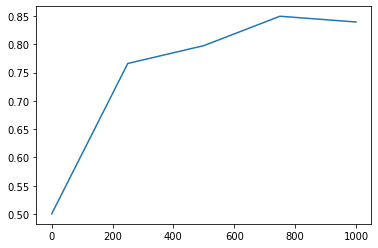

In [ ]:
plt.plot(np.arange(len(uda_val_acc_history)) * val_interval, uda_val_acc_history)

In [ ]:
model = model.to(device)
model.eval()
print("Accuracy testing:", validate(model, test_loader, device))

Accuracy testing: (tensor(0.5376, device='cuda:0'), tensor(0.8608, device='cuda:0'))


**RESULTADO** El modelo UDA entrenado ahora con todos los datos en vez de solo 20 también alcanza un accuracy de 86%, la diferencia es que ahora lo logra en 800 pasos en vez de 5.000.

## Actividad 6

De al menos una ventajas y una desventajas pueden haber entre usar un preentrenamiento como contrastive learning frente a usar UDA.

In [1]:
R = 'Una ventaja de UDA es que con pocas etiquetas logra un buen accuracy, en algunas ocaciones casi tan bueno como supervisado. Una desventaja es que se necesitan por lo menos algunas etiquetas. La ventaja de Contrastive Learning es que permite generar las etiquetas autom\xE1ticamente, aunque luego hay que usar otro modelo para la clasificacion.' # @param {type: "string"}